## QBUS6840 - Assignment

### 1. Load Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels as sm
import statsmodels.api as smt

In [3]:
# load data
df_raw = pd.read_csv('data/UnderemploymentRate_InSample.csv')

display(df_raw.info())
df_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475 entries, 0 to 474
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  475 non-null    object 
 1   Underemployment Rate  475 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.5+ KB


None

,Date,Underemployment Rate
0,1/06/1978,4.270054
1,1/07/1978,3.933794
2,1/08/1978,4.045333
3,1/09/1978,3.999336
4,1/10/1978,3.722322


In [4]:
df_raw.tail()

,Date,Underemployment Rate
470,1/08/2017,4.348083
471,1/09/2017,4.152602
472,1/10/2017,4.058758
473,1/11/2017,3.982008
474,1/12/2017,4.070490


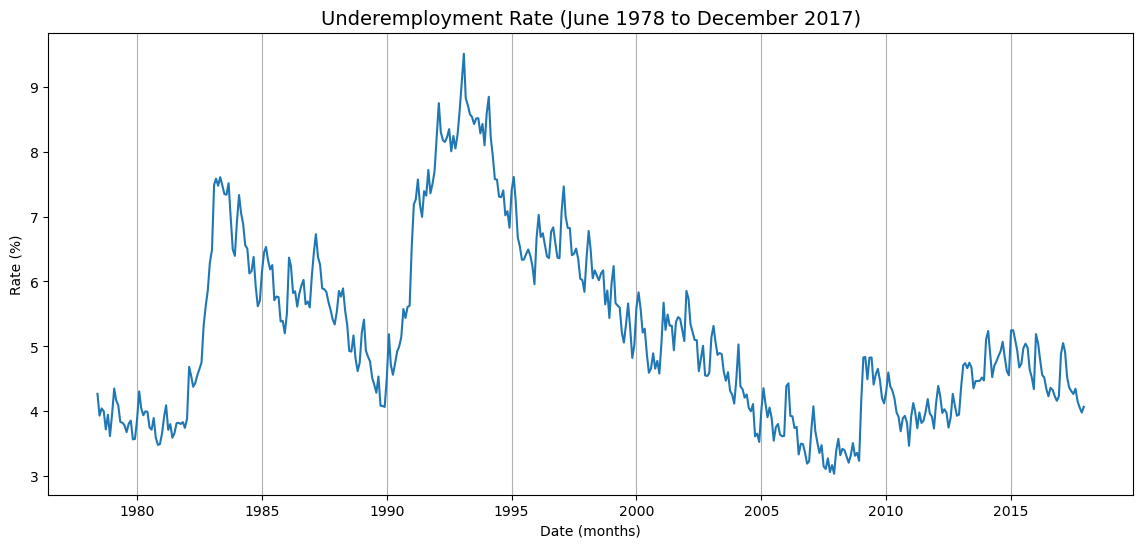

In [5]:
# Convert Date to datetime and set as index
df_ts = df_raw.copy()
df_ts['Date'] = pd.to_datetime(df_ts['Date'], format="%d/%m/%Y") # Fix format to day-month-year
df_ts = df_ts.set_index('Date')

# Plot the training dataset
plt.figure(figsize=(14,6))
plt.title('Underemployment Rate (June 1978 to December 2017)', fontsize=14)
plt.xlabel('Date (months)', fontsize=10)
plt.ylabel('Rate (%)', fontsize=10)

plt.gca().xaxis.grid(True)
plt.plot(df_ts.index, df_ts['Underemployment Rate'])

plt.show()

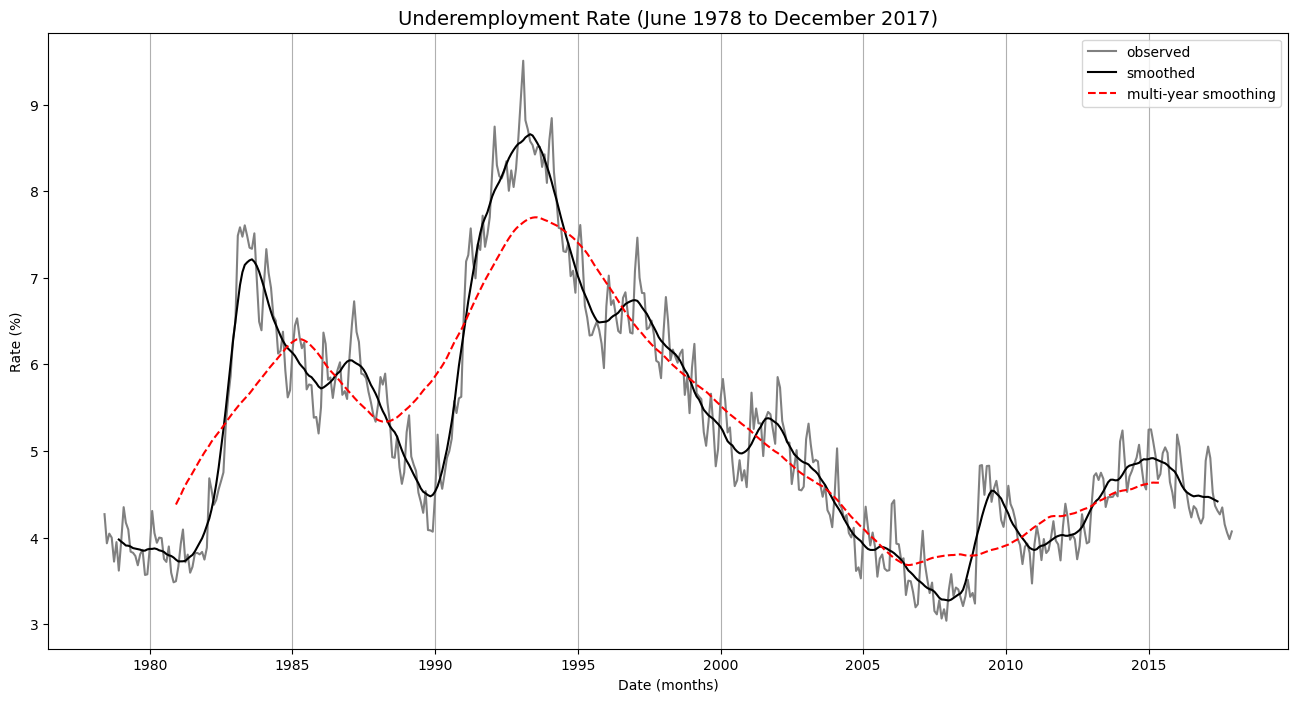

In [7]:
# Can observe an annaul trend, with a peak in January and trough in December
# Additionally, there may be an even greater multi-year trend

# Let's smooth the plot
df_annual_smoothing = df_ts.rolling(12, center=True).mean().rolling(2, center=True).mean().shift(-1)
df_multi_smoothing = df_ts.rolling(60, center=True).mean().rolling(2, center=True).mean().shift(-1)

# Plot the training dataset
plt.figure(figsize=(16,8))
plt.title('Underemployment Rate (June 1978 to December 2017)', fontsize=14)
plt.xlabel('Date (months)', fontsize=10)
plt.ylabel('Rate (%)', fontsize=10)

plt.plot(df_ts.index, df_ts['Underemployment Rate'], label='observed', color='gray')
plt.plot(df_annual_smoothing.index, df_annual_smoothing['Underemployment Rate'], label='smoothed', color='black')
plt.plot(df_multi_smoothing.index, df_multi_smoothing['Underemployment Rate'],
         label='multi-year smoothing', color='red', linestyle='dashed')

plt.gca().xaxis.grid(True)
plt.legend()
plt.show()

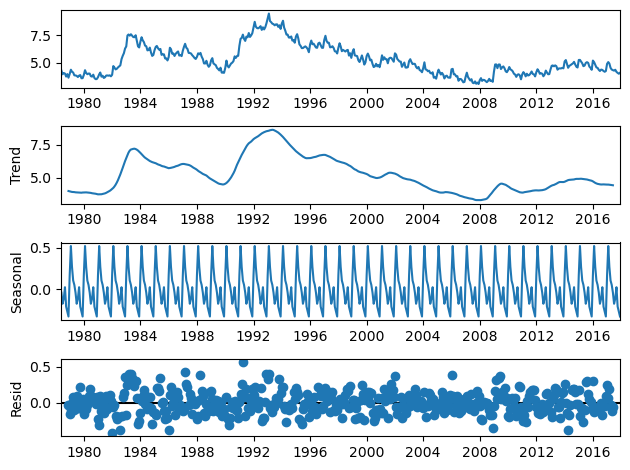

In [12]:
# We can observe more analytically using the statsmodels package for decomposition
## When we allow an additive model, the formula naturally finds an annual seasonal pattern
## If we set the decomposition to multiplicative and/or fix a period > 12 months, we get uneven residuals

decomposition = sm.tsa.seasonal.seasonal_decompose(df_ts,
                                                   model = 'additive',
                                                   period = None,
                                                   #model = 'multiplicative',
                                                   #period = 60,
                                                  )

decomposition.plot()

plt.show()

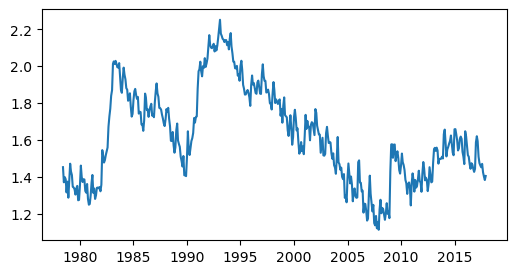

In [30]:
# Transformation:
## (a) log scale
## (b) Differencing
plt.figure(figsize=(6,3))
df_log = np.log(df_ts)
plt.plot(df_log)
plt.show()

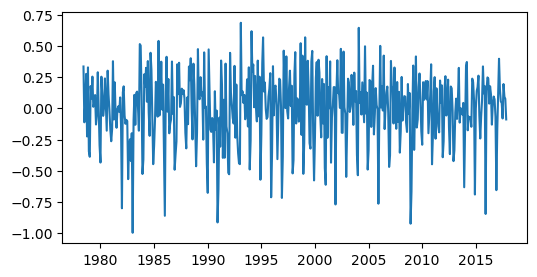

In [31]:
plt.figure(figsize=(6,3))
df_diff = df_ts - df_ts.shift(-1)
plt.plot(df_diff)
plt.show()

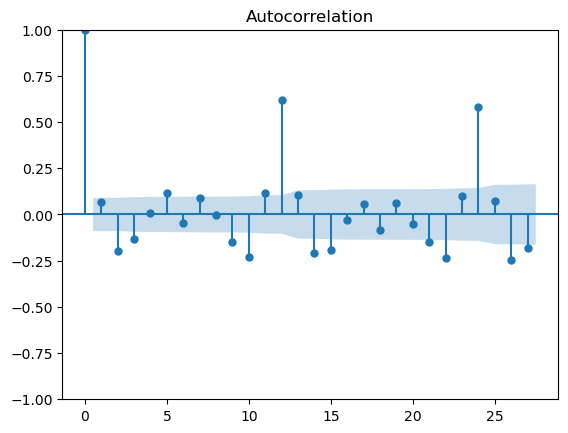

In [45]:
sm.graphics.tsaplots.plot_acf(df_diff['Underemployment Rate'], missing='drop')

plt.show()

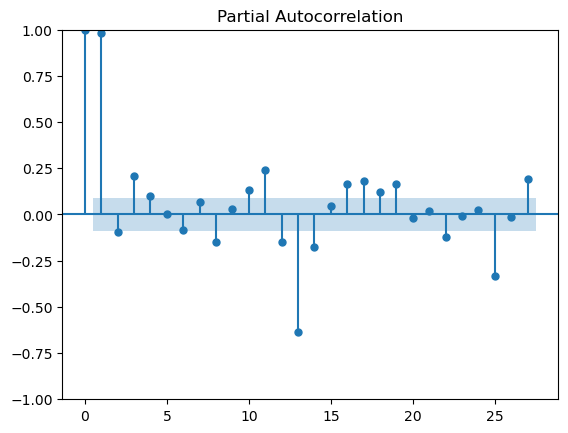

In [51]:
sm.graphics.tsaplots.plot_pacf(df_ts['Underemployment Rate'], method='yw')
plt.show()

In [49]:
df_diff['Underemployment Rate']

Date
1978-06-01    0.336260
1978-07-01   -0.111539
1978-08-01    0.045997
1978-09-01    0.277014
1978-10-01   -0.225118
                ...   
2017-08-01    0.195480
2017-09-01    0.093844
2017-10-01    0.076750
2017-11-01   -0.088482
2017-12-01         NaN
Name: Underemployment Rate, Length: 475, dtype: float64

### Create a Training-Validation Split (expanding window)

In [67]:
df_ts.shape

(475, 1)

In [14]:
# (a) Forecast window of 24, expanding by 12 months each time
# For cross-validation, create an expanding window to forecast on validation data
# Aim to create 5 validation splits
split = 5
train_folds = dict()
val_folds = dict()
forecast_window = 12 # forecast length in months

for n in range(split):
    train_folds[n] = df_ts[:-(split-n)*forecast_window]
    val_folds[n] = df_ts[-(split-n)*forecast_window:]
    val_folds[n] = val_folds[n][:forecast_window] # Limit the test size to the forecast window
    
    print(f'Split {n}: Train - {train_folds[n].shape} | Validation - {val_folds[n].shape}')

Split 0: Train - (415, 1) | Validation - (12, 1)
Split 1: Train - (427, 1) | Validation - (12, 1)
Split 2: Train - (439, 1) | Validation - (12, 1)
Split 3: Train - (451, 1) | Validation - (12, 1)
Split 4: Train - (463, 1) | Validation - (12, 1)


In [ ]:
#(5-0)  5: -84
#       4: -72
#       3: -60
#(5-3)  2: -48
#(5-4)  1: -36
#(5-5)  0: -24

In [17]:
# (b) Alternative: 24 months window, but still only expanding by 12 months
## Calculating rolling: x * 12 + window
# For cross-validation, create an expanding window to forecast on validation data
# Aim to create 5 validation splits
splits = 5
train_folds = dict()
val_folds = dict()
forecast_window = 24 # forecast length in months

for n in range(split):
    train_folds[n] = df_ts[:-(split-n)*12-forecast_window]
    val_folds[n] = df_ts[-(split-n)*12-forecast_window:]
    val_folds[n] = val_folds[n][:forecast_window] # Limit the test size to the forecast window
    
    print(f'Split {n}: Train - {train_folds[n].shape} | Validation - {val_folds[n].shape}')

Split 0: Train - (391, 1) | Validation - (24, 1)
Split 1: Train - (403, 1) | Validation - (24, 1)
Split 2: Train - (415, 1) | Validation - (24, 1)
Split 3: Train - (427, 1) | Validation - (24, 1)
Split 4: Train - (439, 1) | Validation - (24, 1)


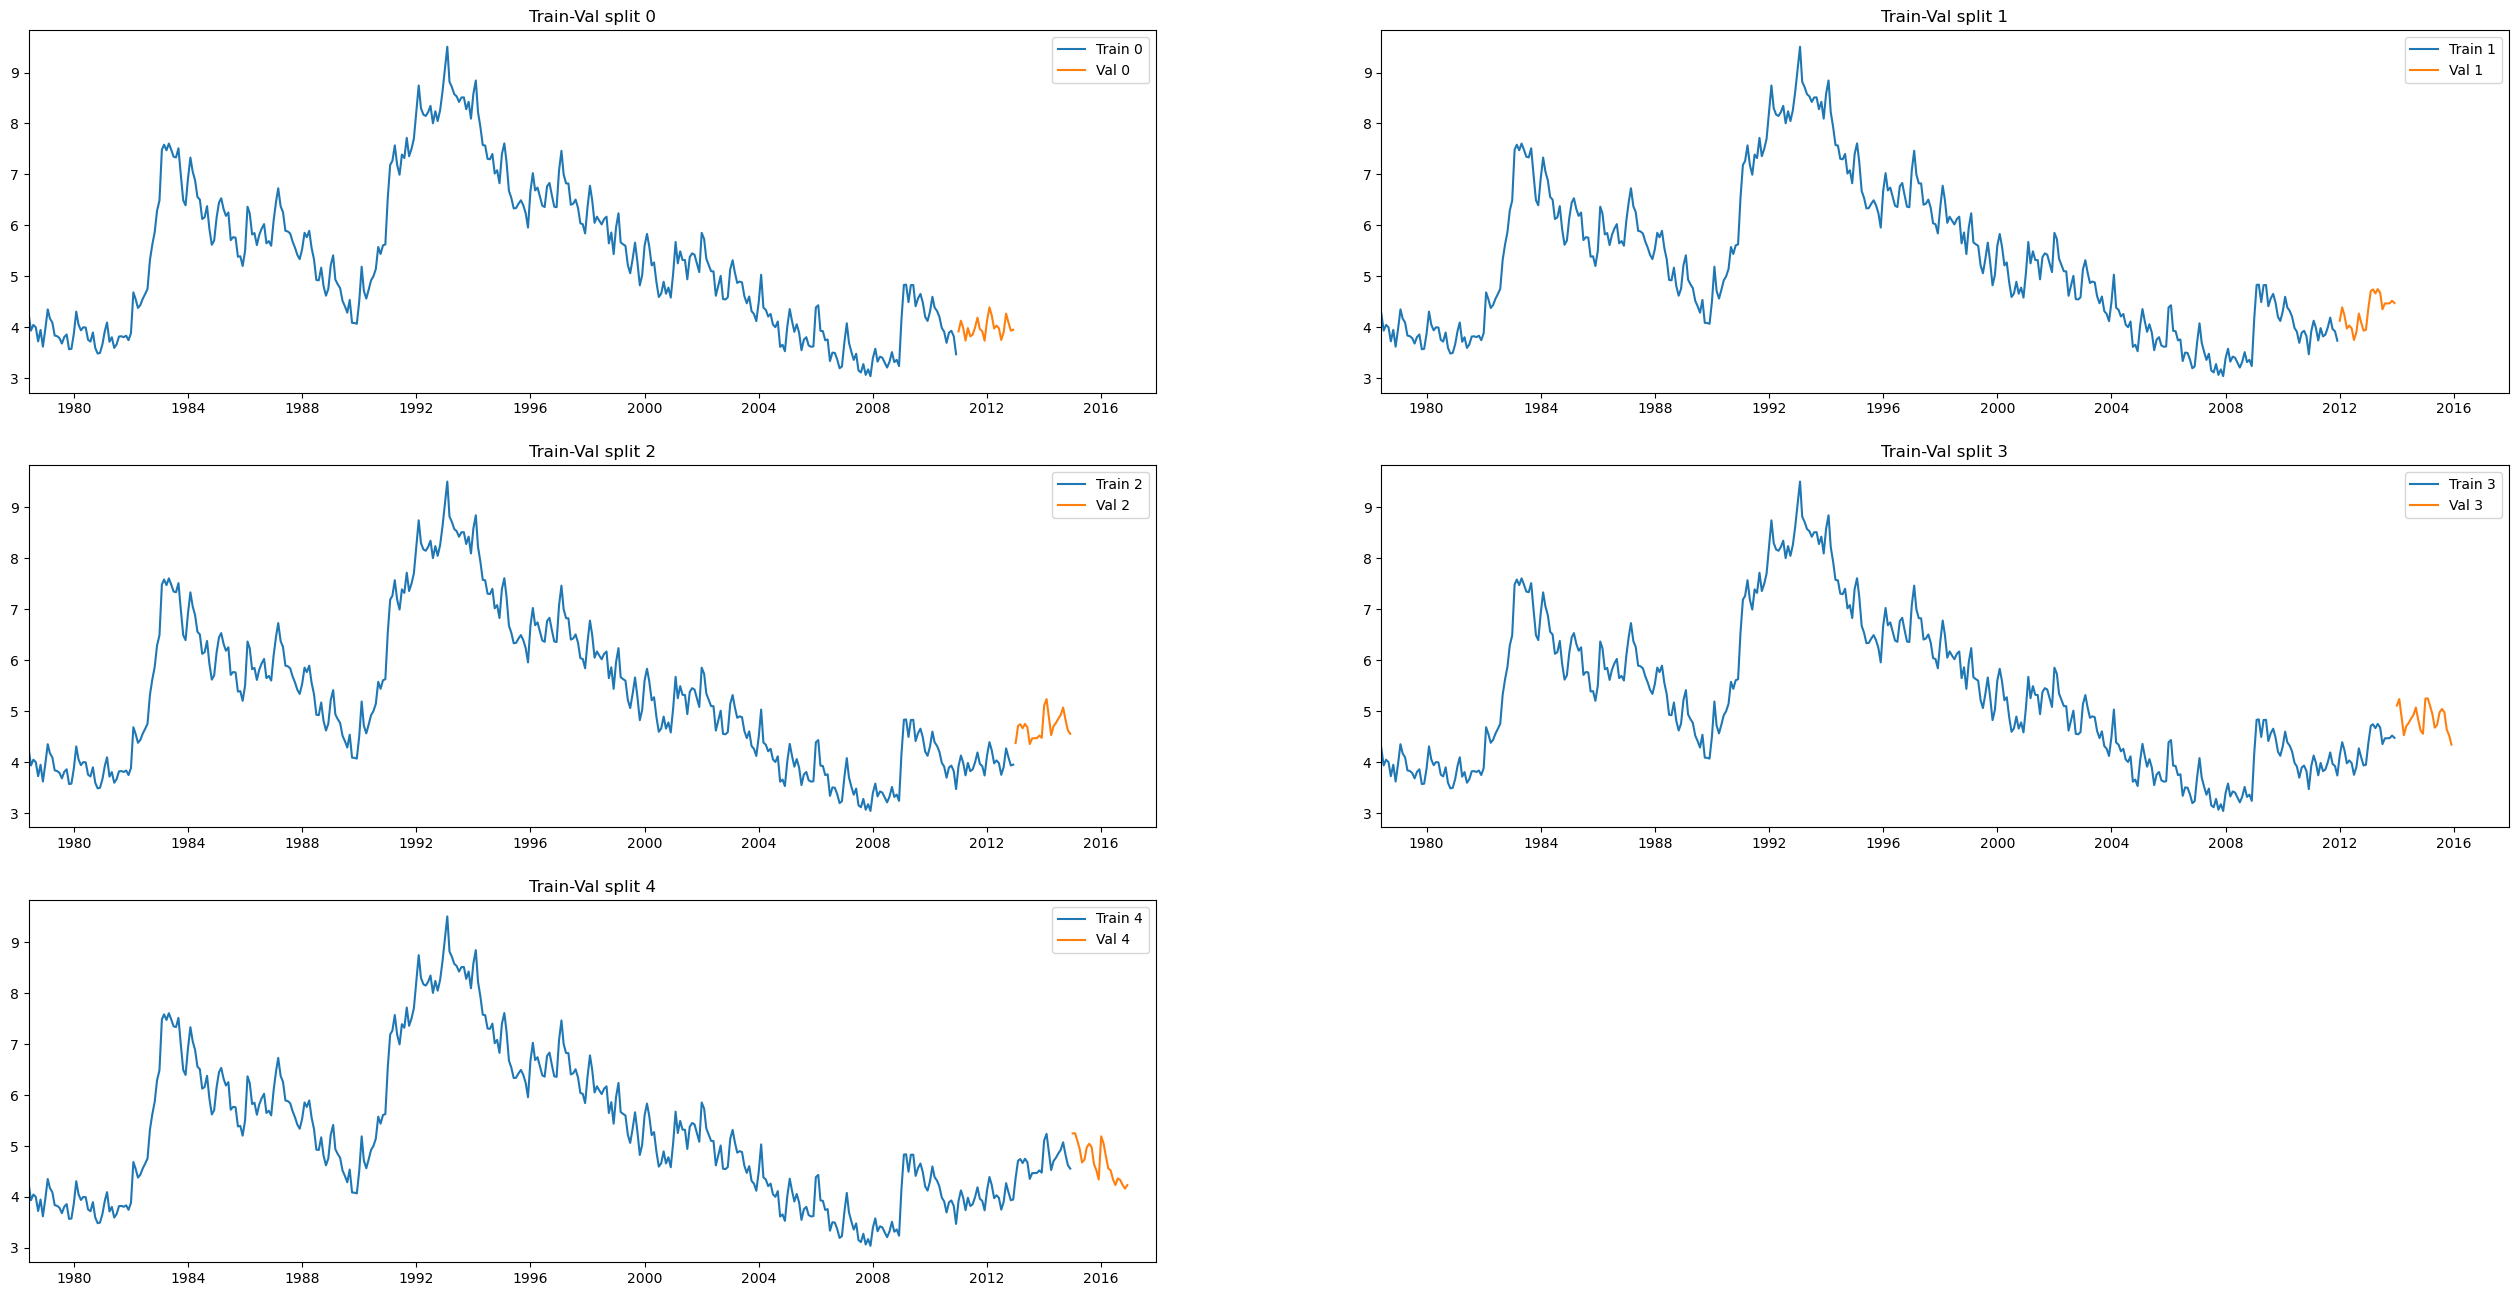

In [16]:
# Plot the train-val splits
plt.figure(figsize=(32,16))
start = min(df_ts.index)
end = xmax=max(df_ts.index)

for i in range(splits):
    ax = plt.subplot(3, 2, i + 1)
    
    ax.set_title(f'Train-Val split {i}')
    ax.set_xlim(start, end)
    ax.plot(train_folds[i], label=f'Train {i}')
    ax.plot(val_folds[i], label=f'Val {i}')
    ax.legend()
    

plt.show()